# What is the relationship between geolocation and weather metrics?
## Introduction
[Weather](https://www.merriam-webster.com/dictionary/weather) is the condition of the atmosphere at a given time for a given location. Differences in weather metrics are attributed to the angle of the [Earth's tilt](https://sciencing.com/tilt-earth-affect-weather-8591690.html), which causes different parts of the Earth to be exposed to the Sun differently. In this study, association between geo-location of cities and four weather metrics were investigated: temperature, humidity, cloudiness, and wind speed. 

## Data analyses
Several Python modules were used in this study. [Citipy](https://pypi.org/project/citipy/) was used to find nearest cities based on geographical coordinates. [JSON] was used to handle data coming from the OpenWeatherData API. [Requests] was used to send requests to the APIs. [Pprint](https://docs.python.org/3/library/pprint.html) allowed JSON data to be presented in a more human-readable fashion. Random numbers were generated using [NumPy](http://www.numpy.org/). Dataframes were generated using [Pandas](https://pandas.pydata.org/). [Matplotlib](https://matplotlib.org/) was used to create scatterplot from the data extracted from JSON files. 

In [1]:
# Dependencies
import os
import pandas as pd
from citipy import citipy # get city and country designations based on latitude and longitude
import numpy as np
from pprint import pprint
from config import api_key
import matplotlib.pyplot as plt
import json
import requests
import datetime as dt # to put a datestamp on the outputs

### Creating a list of cities
To ensure that the selection of cities was random, 1500 random numbers between -90 and 90 (for latitude) and between -180 and 180 (for longitude) were generated. [Latitude](https://www.nasa.gov/audience/forstudents/k-4/dictionary/Latitude.html) is a geographic location metric expressing a point's distance north (positive) or south (negative) of the Equator while [longitude](https://www.nasa.gov/audience/forstudents/k-4/dictionary/Longitude.html) indicates the point's distance east or west from the [Prime Meridian](https://gisgeography.com/prime-greenwich-meridian/) in England. [Coordinates](https://www.britannica.com/science/latitude) are pairs of latitudes and longitudes that point to different locations on Earth. 

In [2]:
# Create a random list of latitudes and longitudes
# np.random.uniform makes sure that all the numbers in the range get equal chance of getting picked

latitudes = np.random.uniform(-90, 90, size = 2000) # 500 random numbers from -90 to 90 deg latitude
longitudes = np.random.uniform(-180, 180, size = 2000) # 500 random numbers from -180 to 180 deg longitude

coordinates = list(zip(latitudes, longitudes))

[Oceans](https://www.oceanicinstitute.org/aboutoceans/aquafacts.html) cover 71% of the Earth's surface, which indicates that there is a high chance that any randomly generated coordinate points to water. Hence, it was important to find the closest cities to these points.

In [3]:
# Nearby cities per latitude-longitude pair
cities = []

for coord in coordinates:
    lat, lon = coord
    cities.append(citipy.nearest_city(lat, lon))

In [4]:
# Set of nearby cities
city_names = []
country = []

for city in cities:
    city_names.append(city.city_name) # loop through the city coordinates to get the city names
    country.append(city.country_code) # loop through the city coordinates to get the country codes
    
city_dict ={
    "city": city_names,
    "country": country,
    "latitude": latitudes,
    "longitude": longitudes
           }    

city_df = pd.DataFrame(city_dict)
city_df = city_df.drop_duplicates(["city","country"]) # drop city-country duplicates
city_df = city_df.dropna() # drop rows with missing values

In [5]:
# Add new columns
city_df["Temperature (F)"] = ""
city_df["Humidity (%)"] = ""
city_df["Cloudiness (%)"] = ""
city_df["Wind Speed (mph)"] = ""
city_df.head()

,city,country,latitude,longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph)
0,sentyabrskiy,ru,43.709374,155.037098,,,,
1,tuatapere,nz,-45.780900,161.587972,,,,
2,taolanaro,mg,-85.748560,62.670054,,,,
3,rikitea,pf,-15.553911,-120.931544,,,,
4,atuona,pf,-14.264646,-136.891192,,,,


In [6]:
# Get JSON file containing city ID (downloaded)
filepath = os.path.join("Resources","city.list.json")
with open(filepath) as json_file:
    json_data = json.load(json_file)

In [7]:
# Get the city name, country code, and city ID 
# City IDs are recommended by the OpenWeatherMap API because they are unique identifiers. 
# There could be cities in the list with the same name but are located in different countries.

ct_name = []
co_name = []
ct_ID = []

for i in json_data:
    ct_name.append(i["name"]) # city name from JSON file
    co_name.append(i["country"]) # country name from JSON file
    ct_ID.append(i["id"]) # city ID from JSON file

In [8]:
# Put the JSON-sourced data into a dataframe
json_dict = {
    "city": ct_name,
    "country": co_name,
    "city ID": ct_ID}

json_df = pd.DataFrame(json_dict)
json_df["city"] = json_df["city"].str.lower() # make the letters lowercase
json_df["country"] = json_df["country"].str.lower() # make the letters lowercase
json_df.head()

,city,country,city ID
0,hurzuf,ua,707860
1,novinki,ru,519188
2,gorkhā,np,1283378
3,state of haryāna,in,1270260
4,holubynka,ua,708546


In [9]:
# Merge json_df and city_df
city_df2 = pd.merge(city_df,json_df, on = ["city", "country"])
city_df2 = city_df2.drop_duplicates(["city", "country"])
print(f"There are {len(city_df2)} cities in this dataframe.")
city_df2.head()

There are 669 cities in this dataframe.


,city,country,latitude,longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph),city ID
0,tuatapere,nz,-45.780900,161.587972,,,,,2180815
1,rikitea,pf,-15.553911,-120.931544,,,,,4030556
2,atuona,pf,-14.264646,-136.891192,,,,,4020109
3,soure,br,-0.624670,-48.947374,,,,,3387204
4,hobart,au,-85.011998,143.283528,,,,,2163355


In [10]:
# Save list of nearby cities (for geo-mapping (see Geolocations_WeatherPy.ipynb))
# Get the date today for the file date-stamp
today = dt.datetime.today().strftime('%Y%m%d')

# save the dataframe as a csv file 
city_df2.to_csv('city_list_{}.csv'.format(today), index = False, encoding = 'utf-8')

## Get the weather for each city through the OpenWeatherData API

In [11]:
# Formulate the query URL
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Loop through the rows to get the different cities and countries
for index, row in city_df2.iterrows():
    x = row["city"]
    y = row["country"]
    
    # Create a variable for iteration through the dataframe
    city_ID = row["city ID"]
    
    # Create a query URL
    query_url = f"{url}&appid={api_key}&id={city_ID}&units={units}"
    
    # Create a request and JSON-ify
    print(f"Retrieving information for Index {index}: {x},{y} (ID: {city_ID}).")
    response = requests.get(query_url)
    response_json = response.json()
    
    # Extract response
    try:
        print(f"{x},{y} (ID: {city_ID}) has {response_json['clouds']['all']}% cloudiness.")
        
        city_df2.loc[index, "Cloudiness (%)"] = response_json["clouds"]["all"]
        city_df2.loc[index, "Humidity (%)"] = response_json["main"]["humidity"]
        city_df2.loc[index, "Wind Speed (mph)"] = response_json["wind"]["speed"]
        city_df2.loc[index, "Temperature (F)"] = response_json["main"]["temp"]
    
    except (KeyError, IndexError):
        print("The city is not on the list. It will rain meatballs!")
    
    print("----------")

Retrieving information for Index 0: tuatapere,nz (ID: 2180815).
tuatapere,nz (ID: 2180815) has 56% cloudiness.
----------
Retrieving information for Index 1: rikitea,pf (ID: 4030556).
rikitea,pf (ID: 4030556) has 8% cloudiness.
----------
Retrieving information for Index 2: atuona,pf (ID: 4020109).
atuona,pf (ID: 4020109) has 8% cloudiness.
----------
Retrieving information for Index 3: soure,br (ID: 3387204).
soure,br (ID: 3387204) has 0% cloudiness.
----------
Retrieving information for Index 4: hobart,au (ID: 2163355).
hobart,au (ID: 2163355) has 40% cloudiness.
----------
Retrieving information for Index 6: whitehorse,ca (ID: 6180550).
whitehorse,ca (ID: 6180550) has 75% cloudiness.
----------
Retrieving information for Index 7: tuktoyaktuk,ca (ID: 6170031).
tuktoyaktuk,ca (ID: 6170031) has 90% cloudiness.
----------
Retrieving information for Index 8: punta arenas,cl (ID: 3874787).
punta arenas,cl (ID: 3874787) has 90% cloudiness.
----------
Retrieving information for Index 9: qua

vestmannaeyjar,is (ID: 3412093) has 92% cloudiness.
----------
Retrieving information for Index 81: vila franca do campo,pt (ID: 8010690).
vila franca do campo,pt (ID: 8010690) has 75% cloudiness.
----------
Retrieving information for Index 83: bethel,us (ID: 4182260).
bethel,us (ID: 4182260) has 20% cloudiness.
----------
Retrieving information for Index 94: maua,ke (ID: 187231).
maua,ke (ID: 187231) has 88% cloudiness.
----------
Retrieving information for Index 95: tiksi,ru (ID: 2015306).
tiksi,ru (ID: 2015306) has 48% cloudiness.
----------
Retrieving information for Index 96: ust-nera,ru (ID: 2120048).
ust-nera,ru (ID: 2120048) has 64% cloudiness.
----------
Retrieving information for Index 97: jamestown,sh (ID: 3370903).
jamestown,sh (ID: 3370903) has 88% cloudiness.
----------
Retrieving information for Index 98: nelson bay,au (ID: 2155562).
nelson bay,au (ID: 2155562) has 75% cloudiness.
----------
Retrieving information for Index 99: lima,pe (ID: 3936456).
lima,pe (ID: 3936456

saskylakh,ru (ID: 2017155) has 0% cloudiness.
----------
Retrieving information for Index 162: grand gaube,mu (ID: 934479).
grand gaube,mu (ID: 934479) has 20% cloudiness.
----------
Retrieving information for Index 163: mar del plata,ar (ID: 3430863).
mar del plata,ar (ID: 3430863) has 0% cloudiness.
----------
Retrieving information for Index 164: severo-kurilsk,ru (ID: 2121385).
severo-kurilsk,ru (ID: 2121385) has 32% cloudiness.
----------
Retrieving information for Index 165: derzhavinsk,kz (ID: 1524606).
derzhavinsk,kz (ID: 1524606) has 88% cloudiness.
----------
Retrieving information for Index 166: knysna,za (ID: 988698).
knysna,za (ID: 988698) has 0% cloudiness.
----------
Retrieving information for Index 167: port hawkesbury,ca (ID: 6111867).
port hawkesbury,ca (ID: 6111867) has 90% cloudiness.
----------
Retrieving information for Index 168: coxim,br (ID: 3465228).
coxim,br (ID: 3465228) has 0% cloudiness.
----------
Retrieving information for Index 169: dori,bf (ID: 2361082

hambantota,lk (ID: 1244926) has 0% cloudiness.
----------
Retrieving information for Index 256: paidha,ug (ID: 226853).
paidha,ug (ID: 226853) has 48% cloudiness.
----------
Retrieving information for Index 257: ugento,it (ID: 2522833).
ugento,it (ID: 2522833) has 75% cloudiness.
----------
Retrieving information for Index 258: bokoro,td (ID: 2434985).
bokoro,td (ID: 2434985) has 12% cloudiness.
----------
Retrieving information for Index 259: mpongwe,zm (ID: 905789).
mpongwe,zm (ID: 905789) has 0% cloudiness.
----------
Retrieving information for Index 260: lebu,cl (ID: 3883457).
lebu,cl (ID: 3883457) has 64% cloudiness.
----------
Retrieving information for Index 261: fort dodge,us (ID: 4857486).
fort dodge,us (ID: 4857486) has 90% cloudiness.
----------
Retrieving information for Index 262: hidalgotitlan,mx (ID: 3527113).
hidalgotitlan,mx (ID: 3527113) has 75% cloudiness.
----------
Retrieving information for Index 263: bredasdorp,za (ID: 1015776).
bredasdorp,za (ID: 1015776) has 88

kenai,us (ID: 5866063) has 1% cloudiness.
----------
Retrieving information for Index 333: gazanjyk,tm (ID: 161974).
gazanjyk,tm (ID: 161974) has 8% cloudiness.
----------
Retrieving information for Index 334: nhulunbuy,au (ID: 2064735).
nhulunbuy,au (ID: 2064735) has 40% cloudiness.
----------
Retrieving information for Index 335: monrovia,lr (ID: 2274895).
monrovia,lr (ID: 2274895) has 40% cloudiness.
----------
Retrieving information for Index 336: aklavik,ca (ID: 5882953).
aklavik,ca (ID: 5882953) has 90% cloudiness.
----------
Retrieving information for Index 337: westport,nz (ID: 2206900).
westport,nz (ID: 2206900) has 0% cloudiness.
----------
Retrieving information for Index 338: hofn,is (ID: 2630299).
hofn,is (ID: 2630299) has 88% cloudiness.
----------
Retrieving information for Index 339: lubango,ao (ID: 3347762).
lubango,ao (ID: 3347762) has 20% cloudiness.
----------
Retrieving information for Index 340: san carlos,bo (ID: 3905775).
san carlos,bo (ID: 3905775) has 8% cloud

hun,ly (ID: 2216645) has 0% cloudiness.
----------
Retrieving information for Index 447: colon,pa (ID: 3712076).
colon,pa (ID: 3712076) has 40% cloudiness.
----------
Retrieving information for Index 448: nouadhibou,mr (ID: 2377457).
nouadhibou,mr (ID: 2377457) has 0% cloudiness.
----------
Retrieving information for Index 449: arman,ru (ID: 2127060).
arman,ru (ID: 2127060) has 44% cloudiness.
----------
Retrieving information for Index 450: jesup,us (ID: 4202810).
jesup,us (ID: 4202810) has 1% cloudiness.
----------
Retrieving information for Index 452: kalmunai,lk (ID: 1242110).
kalmunai,lk (ID: 1242110) has 80% cloudiness.
----------
Retrieving information for Index 453: suluq,ly (ID: 81604).
suluq,ly (ID: 81604) has 88% cloudiness.
----------
Retrieving information for Index 454: jackson,us (ID: 4241691).
jackson,us (ID: 4241691) has 90% cloudiness.
----------
Retrieving information for Index 472: tecoanapa,mx (ID: 3516171).
tecoanapa,mx (ID: 3516171) has 100% cloudiness.
---------

taltal,cl (ID: 3870243) has 0% cloudiness.
----------
Retrieving information for Index 546: port hedland,au (ID: 7839630).
port hedland,au (ID: 7839630) has 0% cloudiness.
----------
Retrieving information for Index 548: mahanje,tz (ID: 155285).
mahanje,tz (ID: 155285) has 20% cloudiness.
----------
Retrieving information for Index 549: rajpipla,in (ID: 1258819).
rajpipla,in (ID: 1258819) has 0% cloudiness.
----------
Retrieving information for Index 550: opuwo,na (ID: 3354077).
opuwo,na (ID: 3354077) has 0% cloudiness.
----------
Retrieving information for Index 551: hirara,jp (ID: 1862505).
hirara,jp (ID: 1862505) has 75% cloudiness.
----------
Retrieving information for Index 552: belyy yar,ru (ID: 1510370).
belyy yar,ru (ID: 1510370) has 68% cloudiness.
----------
Retrieving information for Index 554: kununurra,au (ID: 2068110).
kununurra,au (ID: 2068110) has 80% cloudiness.
----------
Retrieving information for Index 555: znamenskoye,ru (ID: 462305).
znamenskoye,ru (ID: 462305) ha

tabou,ci (ID: 2281120) has 88% cloudiness.
----------
Retrieving information for Index 645: yanam,in (ID: 1252795).
yanam,in (ID: 1252795) has 32% cloudiness.
----------
Retrieving information for Index 646: hilton head island,us (ID: 4581833).
hilton head island,us (ID: 4581833) has 1% cloudiness.
----------
Retrieving information for Index 647: rock springs,us (ID: 5836898).
rock springs,us (ID: 5836898) has 20% cloudiness.
----------
Retrieving information for Index 649: richards bay,za (ID: 962367).
richards bay,za (ID: 962367) has 20% cloudiness.
----------
Retrieving information for Index 650: yaring,th (ID: 1604771).
yaring,th (ID: 1604771) has 88% cloudiness.
----------
Retrieving information for Index 651: manta,ec (ID: 3654410).
manta,ec (ID: 3654410) has 75% cloudiness.
----------
Retrieving information for Index 652: eixo,pt (ID: 8010748).
eixo,pt (ID: 8010748) has 40% cloudiness.
----------
Retrieving information for Index 654: mae hong son,th (ID: 1152222).
mae hong son,t

ostersund,se (ID: 2685750) has 64% cloudiness.
----------
Retrieving information for Index 732: groningen,sr (ID: 3384125).
groningen,sr (ID: 3384125) has 20% cloudiness.
----------
Retrieving information for Index 733: arrecife,es (ID: 6360174).
arrecife,es (ID: 6360174) has 75% cloudiness.
----------
Retrieving information for Index 735: bukan,ir (ID: 139889).
bukan,ir (ID: 139889) has 32% cloudiness.
----------
Retrieving information for Index 736: boende,cd (ID: 218680).
boende,cd (ID: 218680) has 92% cloudiness.
----------
Retrieving information for Index 737: sabha,ly (ID: 2212775).
sabha,ly (ID: 2212775) has 0% cloudiness.
----------
Retrieving information for Index 738: ko samui,th (ID: 1154689).
ko samui,th (ID: 1154689) has 20% cloudiness.
----------
Retrieving information for Index 739: teya,ru (ID: 1489656).
teya,ru (ID: 1489656) has 80% cloudiness.
----------
Retrieving information for Index 740: aloleng,ph (ID: 1731298).
aloleng,ph (ID: 1731298) has 24% cloudiness.
------

juneau,us (ID: 5258190) has 90% cloudiness.
----------
Retrieving information for Index 819: sabang,id (ID: 1214026).
sabang,id (ID: 1214026) has 32% cloudiness.
----------
Retrieving information for Index 820: quchan,ir (ID: 119115).
quchan,ir (ID: 119115) has 8% cloudiness.
----------
Retrieving information for Index 821: traverse city,us (ID: 5012495).
traverse city,us (ID: 5012495) has 40% cloudiness.
----------
Retrieving information for Index 822: marinette,us (ID: 5261852).
marinette,us (ID: 5261852) has 90% cloudiness.
----------
Retrieving information for Index 823: hamilton,bm (ID: 3573198).
hamilton,bm (ID: 3573198) has 75% cloudiness.
----------
Retrieving information for Index 825: copala,mx (ID: 3530264).
copala,mx (ID: 3530264) has 100% cloudiness.
----------
Retrieving information for Index 826: izhma,ru (ID: 554830).
izhma,ru (ID: 554830) has 92% cloudiness.
----------
Retrieving information for Index 827: amazar,ru (ID: 2027806).
amazar,ru (ID: 2027806) has 0% cloudin

In [12]:
# Get the date today for the file date-stamp
today = dt.datetime.today().strftime('%Y%m%d')

# save the dataframe as a csv file 
city_df2.to_csv('weather_output_{}.csv'.format(today), index = False, encoding = 'utf-8')

# Preview the dataframe
city_df2.head()

,city,country,latitude,longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph),city ID
0,tuatapere,nz,-45.780900,161.587972,49.74,100,56,8.41,2180815
1,rikitea,pf,-15.553911,-120.931544,71.7,100,8,8.3,4030556
2,atuona,pf,-14.264646,-136.891192,81.15,99,8,14.56,4020109
3,soure,br,-0.624670,-48.947374,80.61,89,0,9.42,3387204
4,hobart,au,-85.011998,143.283528,64.4,68,40,10.29,2163355


## Create scatterplots

In [13]:
# Choose ggplot as style for plots
plt.style.use('ggplot')

# Size of plots
fig_size = plt.rcParams["figure.figsize"] # get current size
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size # customise plot size

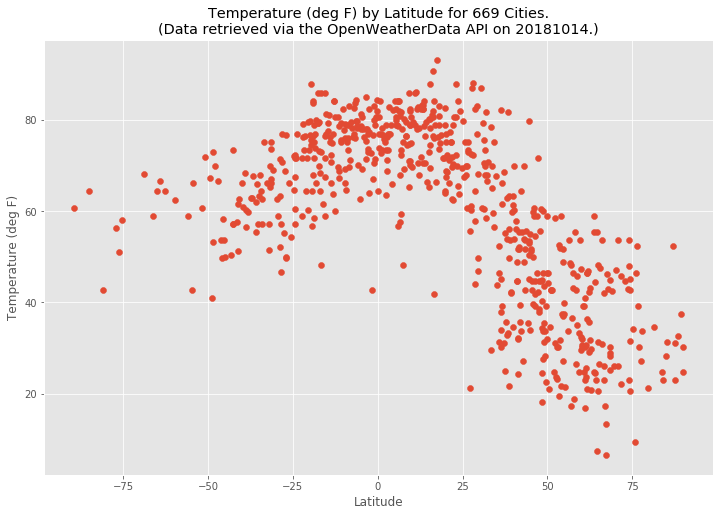

In [14]:
# Latitude vs Temperature
plt.scatter(city_df2["latitude"], city_df2["Temperature (F)"])
plt.xlabel("Latitude")
plt.ylabel("Temperature (deg F)")
plt.title(f"Temperature (deg F) by Latitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/lat_temp_{}.png".format(today))
plt.show()

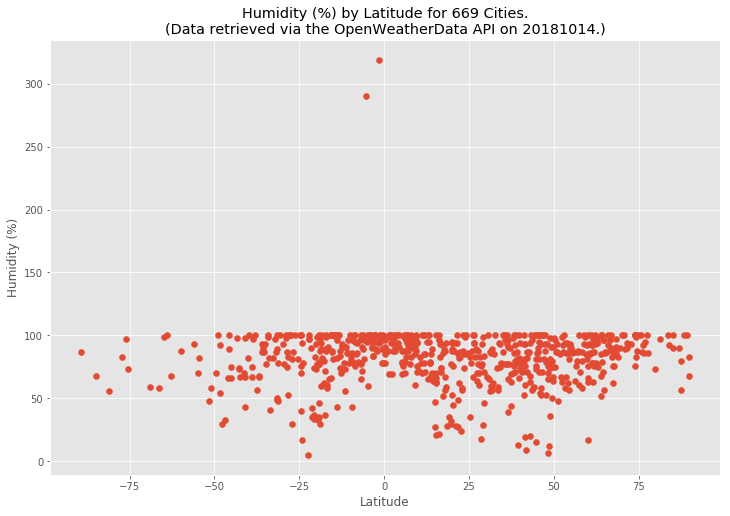

In [15]:
# Latitude vs Humidity
plt.scatter(city_df2["latitude"], city_df2["Humidity (%)"])
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title(f"Humidity (%) by Latitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/lat_hum_{}.png".format(today))
plt.show()

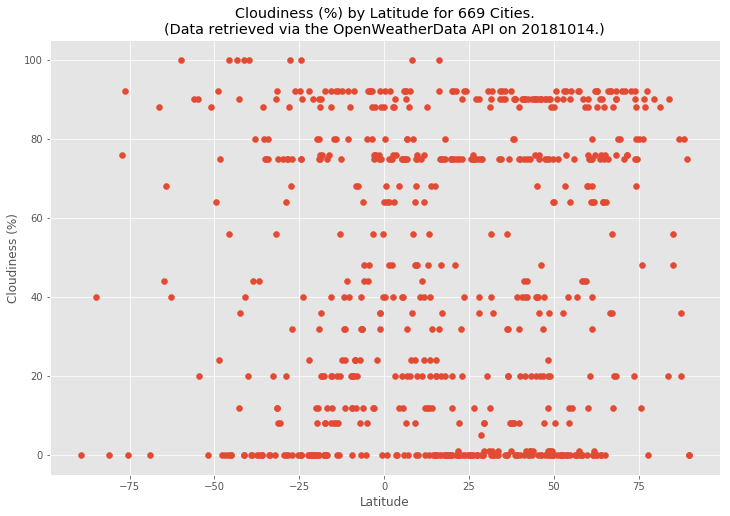

In [16]:
# Latitude vs Cloudiness
plt.scatter(city_df2["latitude"], city_df2["Cloudiness (%)"])
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title(f"Cloudiness (%) by Latitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/lat_cloud_{}.png".format(today))
plt.show()

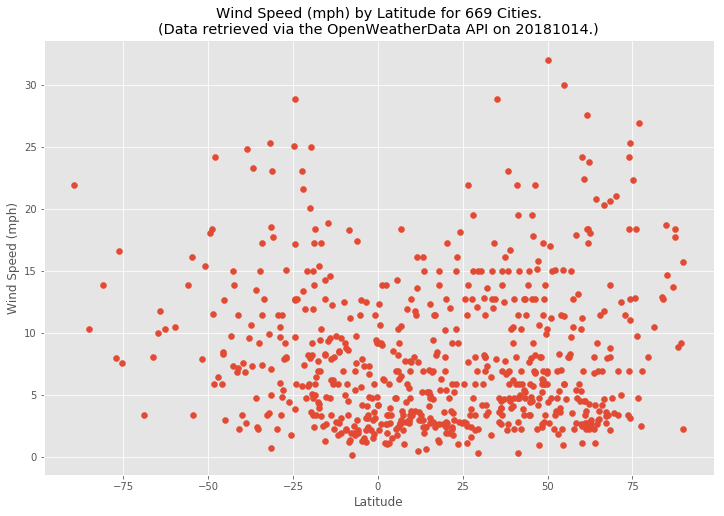

In [17]:
# Latitude vs Wind Speed
plt.scatter(city_df2["latitude"], city_df2["Wind Speed (mph)"])
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Wind Speed (mph) by Latitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/lat_wind_{}.png".format(today))
plt.show()

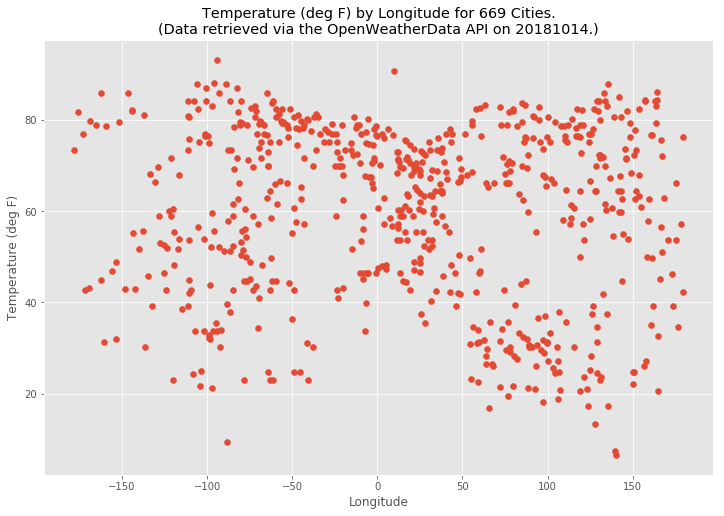

In [18]:
# Longitude vs Temperature
plt.scatter(city_df2["longitude"], city_df2["Temperature (F)"])
plt.xlabel("Longitude")
plt.ylabel("Temperature (deg F)")
plt.title(f"Temperature (deg F) by Longitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/long_temp_{}.png".format(today))
plt.show()

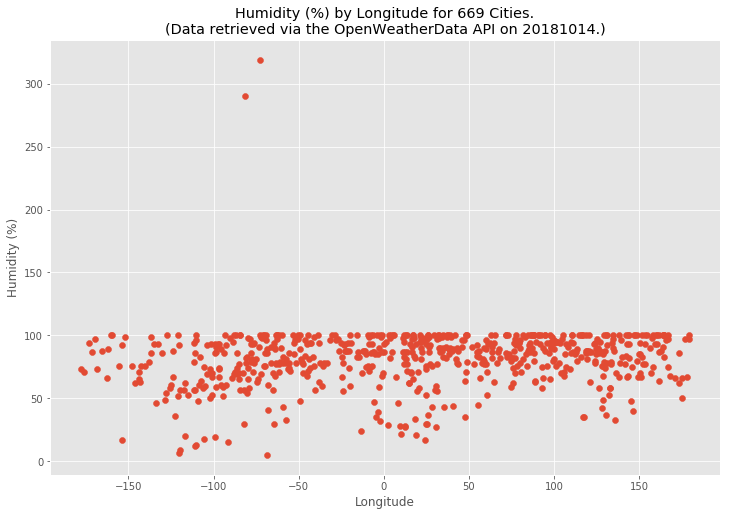

In [19]:
# Longitude vs Humidity
plt.scatter(city_df2["longitude"], city_df2["Humidity (%)"])
plt.xlabel("Longitude")
plt.ylabel("Humidity (%)")
plt.title(f"Humidity (%) by Longitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/long_hum_{}.png".format(today))
plt.show()

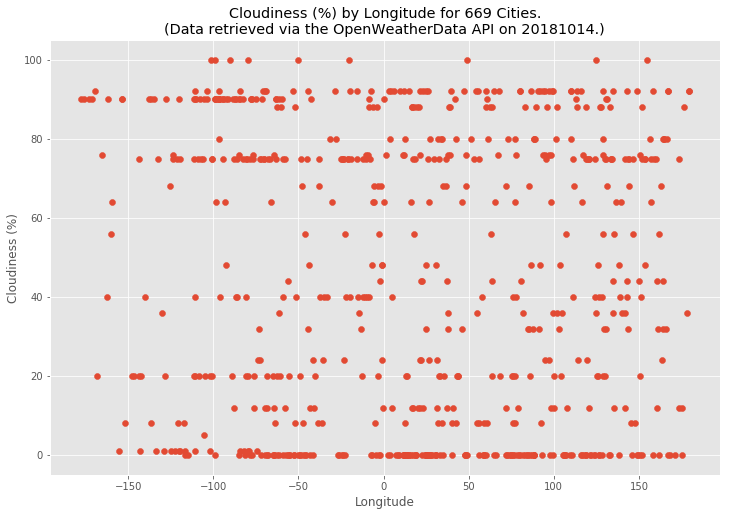

In [20]:
# Longitude vs Cloudiness
plt.scatter(city_df2["longitude"], city_df2["Cloudiness (%)"])
plt.xlabel("Longitude")
plt.ylabel("Cloudiness (%)")
plt.title(f"Cloudiness (%) by Longitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/long_cloud_{}.png".format(today))
plt.show()

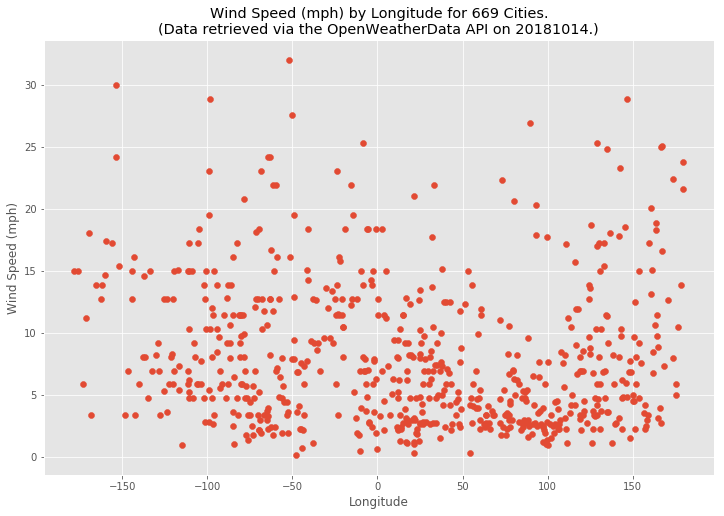

In [21]:
# Longitude vs Wind Speed
plt.scatter(city_df2["longitude"], city_df2["Wind Speed (mph)"])
plt.xlabel("Longitude")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Wind Speed (mph) by Longitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/long_wind_{}.png".format(today))
plt.show()

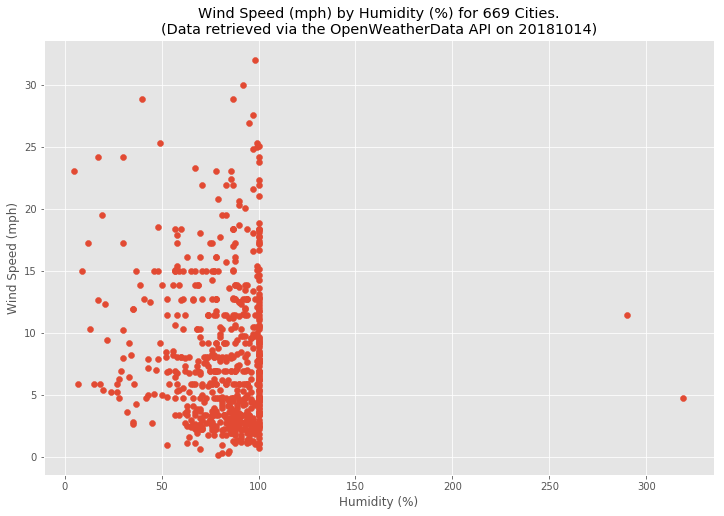

In [22]:
# Humidity vs Wind Speed
plt.scatter(city_df2["Humidity (%)"], city_df2["Wind Speed (mph)"])
plt.xlabel("Humidity (%)")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Wind Speed (mph) by Humidity (%) for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today})")

# Save image
plt.savefig("Images/hum_wind_{}.png".format(today))
plt.show()

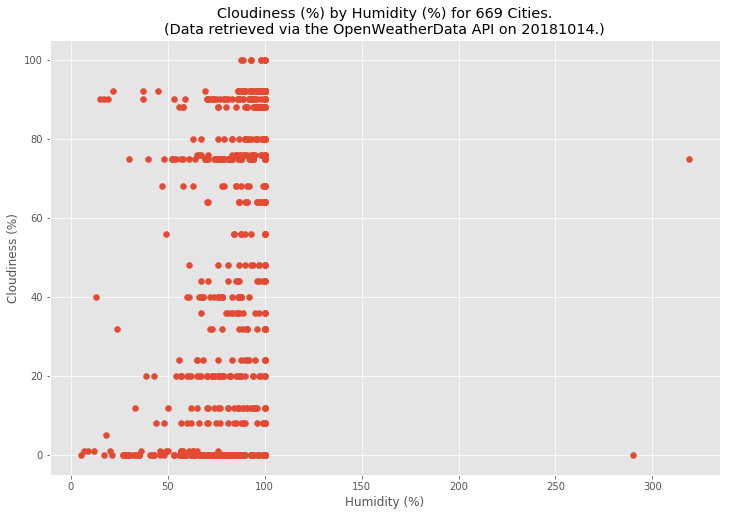

In [23]:
# Humidity vs Cloudiness
plt.scatter(city_df2["Humidity (%)"], city_df2["Cloudiness (%)"])
plt.xlabel("Humidity (%)")
plt.ylabel("Cloudiness (%)")
plt.title(f"Cloudiness (%) by Humidity (%) for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/hum_cloud_{}.png".format(today))
plt.show()

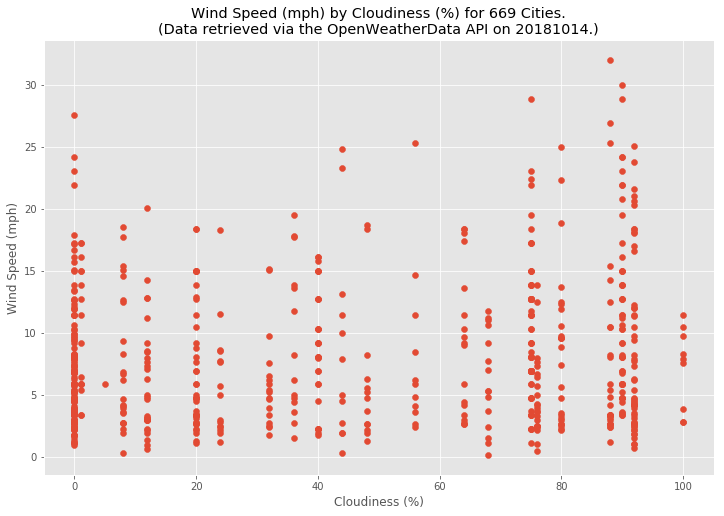

In [24]:
# Humidity vs Wind Speed
plt.scatter(city_df2["Cloudiness (%)"], city_df2["Wind Speed (mph)"])
plt.xlabel("Cloudiness (%)")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Wind Speed (mph) by Cloudiness (%) for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/cloud_wind_{}.png".format(today))
plt.show()